# Project Proposal: Predicting Heart Disease

**Group 11**

## Introduction

Heart disease, a condition affecting the structure or function of the heart, is one of the leading causes of death for people around the world<sup>4,11</sup>. The most common type is coronary heart disease, caused by narrowing of arteries and leading to heart attacks and chest pains (anginas)<sup>5,11</sup>. Thus, prevention and accurate prediction of heart disease is a crucial scientific topic. In this project, we will answer the question: **What are the statistical correlations between given covariables, and how do their correlations impact the predictive power of logistic regression, specifically whether a patient has heart disease or not?**

Current literature on predictive models for diagnosis of heart disease has demonstrated two contradicting results. Some research shows that random forest and K-NN produce the greatest accuracy<sup>2,6,7,10</sup> in contrast to the findings that multinomial logistic regression outperforms other hybrid models<sup>9</sup>.  This does not necessarily suggest that logistic regression is a bad choice, thus, we will still use this model for predicting heart disease<sup>1</sup>.

The data set we will use is the UCI Machine Learning Repository Heart Disease Data Set<sup>8</sup>. This dataset contains a diagnosis of heart disease for each patient (`num`), some descriptive variables (eg. age), and numerous categorical (eg. `cp`) and continuous (eg. `chol`) bodily measurements related to the heart.  All the variables are in Table 1 in Appendix I. 

## Exploratory Data Analysis

In [20]:
library(tidyverse)
library(GGally)
library(gridExtra)
library(cowplot)

In [21]:
# Setting names of columns
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num", show_col_types = FALSE)

# - Reading all of the data from https://archive.ics.uci.edu/ml/datasets/heart+Disease replacing all "?" with NA 
# since the predetermined NA value was "?", and NA is easier to deal with
# - Adding a new column `country` which will help keep track of which hospital the data came from.

cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 0)
switzerland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 1)
hungary_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 2)
va_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 0)

In [22]:
# Counts of NA values in each dataset, and within every column, which allows us to see which columns we should 
# remove early on, and which would likely cause issues (i.e. missing data).
NA_counts <- as.data.frame(cleveland_data[FALSE, ])
x <- substitute(list(cleveland_data, switzerland_data, hungary_data, va_data))

for (i in as.list(x)[-1]) {
    NA_counts[nrow(NA_counts) + 1,] <- map_df(get(i), ~sum(is.na(.x)))
    rownames(NA_counts)[nrow(NA_counts)] <- deparse(i)
}
NA_counts

age sex cp trestbps chol fbs restecg thalach exang oldpeak
cleveland_data   0   0   0   0        0    0  0        0       0     0     
switzerland_data 0   0   0   2        0   75  1        1       1     6     
hungary_data     0   0   0   1       23    8  1        1       1     0     
va_data          0   0   0  56        7    7  0       53      53    56     
                 slope ca  thal num country
cleveland_data     0     4   2  0   0      
switzerland_data  17   118  52  0   0      
hungary_data     190   291 266  0   0      
va_data          102   198 166  0   0

In [23]:
# Choosing to drop columns slope, ca, thal, fbs, exang, and oldpeak because they have too many NA values, which can 
# lead to inaccurate results and this will allow us to have more observations for future analysis. 
data_tidy_multi <- rbind(cleveland_data, switzerland_data, hungary_data, va_data) %>%
    select(-slope, -ca, -thal, -fbs, -exang, -oldpeak) %>%
    na.omit()

num_counts_multi <- data_tidy_multi %>%
    group_by(num) %>%
    summarize(counts = n(), proportions = counts/nrow(data_tidy_multi))
num_counts_multi

num counts proportions
1 0   373    0.44831731 
2 1   244    0.29326923 
3 2   100    0.12019231 
4 3    91    0.10937500 
5 4    24    0.02884615

In [24]:
# There is large class imnalance within data set, particularly for severe heart disease
# As our analysis is focused on finding whether heart disease is present at all, we are not interested in severity
# of condition. 
# We binarized the output by grouping categories 1-4 into case of having heart disease. 
data_tidy <- data_tidy_multi %>%
    mutate(num = ifelse(num == 0, 0, 1)) %>%
    mutate(num = as_factor(num), cp = as_factor(cp), sex = as_factor(sex), restecg = as_factor(restecg), country = as_factor(country)) %>%
    select(age, sex, cp, trestbps, chol, restecg, thalach, country, num)

num_counts <- data_tidy %>%
    group_by(num) %>%
    summarize(counts = n(), proportions = counts/nrow(data_tidy))

num_counts
head(data_tidy)

num counts proportions
1 0   373    0.4483173  
2 1   459    0.5516827

age sex cp trestbps chol restecg thalach country num
1 63  1   1  145      233  2       150     0       0  
2 67  1   4  160      286  2       108     0       1  
3 67  1   4  120      229  2       129     0       1  
4 37  1   3  130      250  0       187     0       0  
5 41  0   2  130      204  2       172     0       0  
6 56  1   2  120      236  0       178     0       0

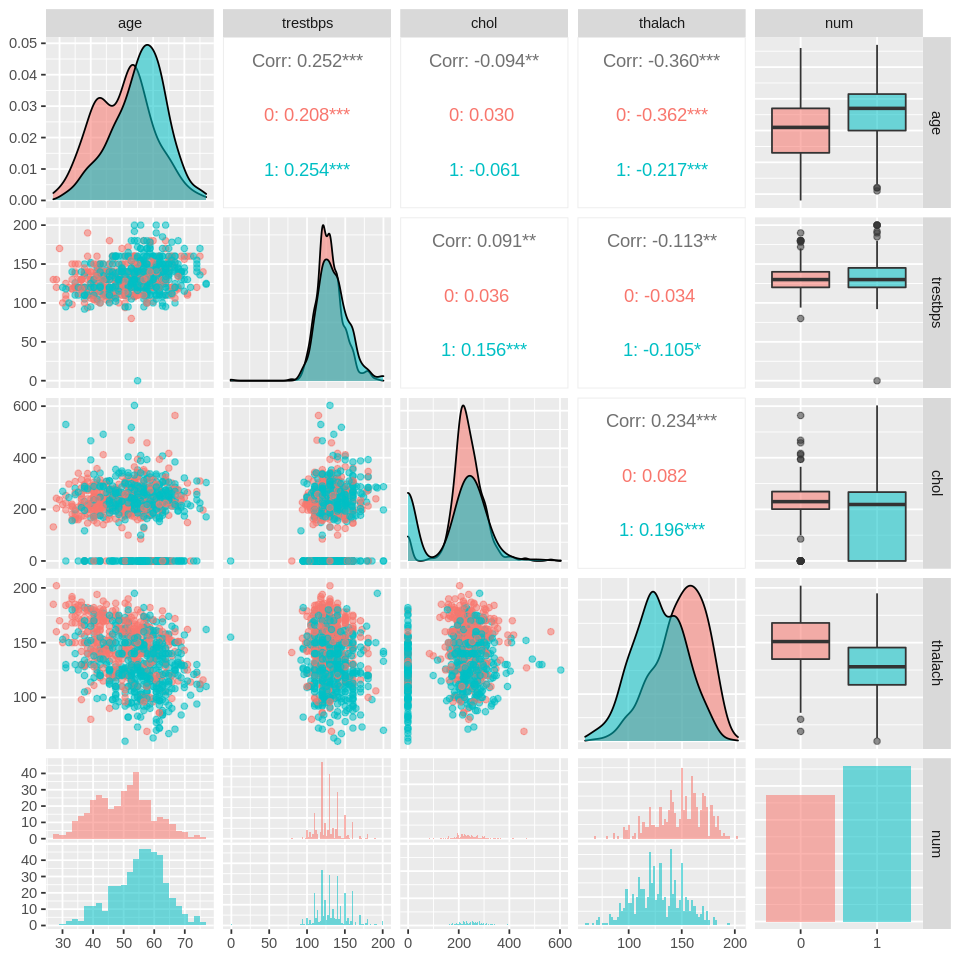

In [25]:
# Now that is much more balanced, we begin variable selection by first making covariance matrix between all 
# continuous variables to see any interdependencies between variables (i.e. colinearity)
options(repr.plot.width = 8, repr.plot.height = 8)

covariance_plot <- data_tidy %>%
    select(age, trestbps, chol, thalach, num) %>%
    ggpairs(aes(colour = num, alpha = 0.5), lower = list(combo = wrap("facethist", binwidth = 2)))

covariance_plot

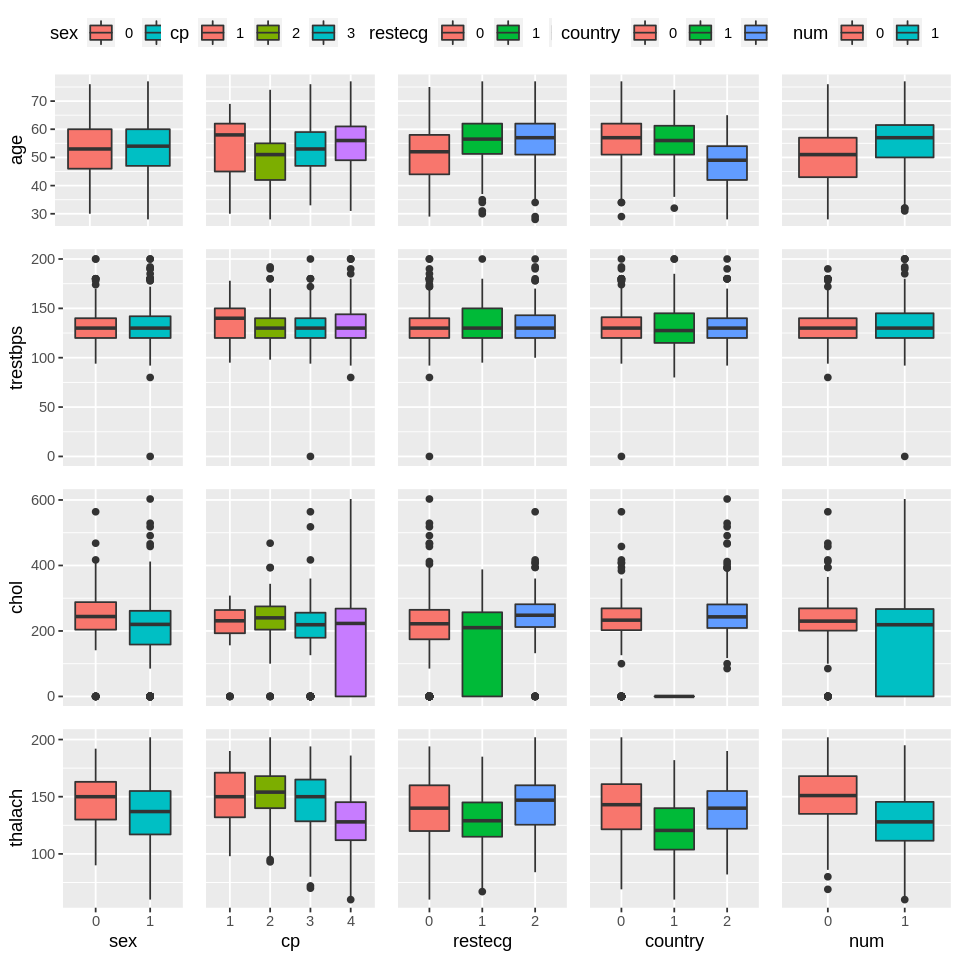

In [31]:
# As there seems to be skewed distribution with variable chol, we perform further investigation into categorical
# variables using a boxplot matrix

options(repr.plot.width = 8, repr.plot.height = 8)

numeric_variables <- colnames(select(data_tidy, where(is.numeric)))
categorical_variables <- colnames(select(data_tidy, where(is.factor)))

index <- 1

for (j in categorical_variables) {
    
    count <- 1
    for (i in numeric_variables) {
        p <- data_tidy %>% ggplot() + 
            geom_boxplot(aes(x = .data[[j]], y = .data[[i]], fill = .data[[j]]))
        
        if (count == 1) {
            p <- p + theme(legend.position = "top")
        } else {
            p <- p + theme(legend.position = "none")
        } 
        if (index != 1) {
            p <- p + 
                theme(axis.title.y=element_blank(),
                axis.text.y=element_blank(),
                axis.ticks.y=element_blank())
        } 
        if (count != 4) {
            p <- p + 
                theme(axis.title.x=element_blank(),
                axis.text.x=element_blank(),
                axis.ticks.x=element_blank())
        } 
        
        assign(paste0("plot", toString(count)), p)
        count <- count + 1
    }
    
    g <- plot_grid(plot1, plot2, plot3, plot4, ncol = 1)
    assign(paste0("g", toString(index)), g)
    index <- index + 1
}

plot_grid(g1, g2, g3, g4, g5, ncol = 5)

We can see that in all plots with `chol`, there are so many values of `chol` = 0 that the quartiles of the boxplots get skewed. Cholesterol performs important roles in our body, such as making hormones, and is requied<sup>3</sup>, which  means it is illogical for your body to have 0 mg/dl of cholesterol. 

In [27]:
# Since this measurement is likely a mistake in the data collection process, and is skewing the variable distribution
# (including mean and standard deviation), we removed all rows with chol being 0 
summary_table <- data_tidy %>%
    mutate(across(age:num, ~as.numeric(as.character(.x)))) %>%
    select(-num) %>%
    pivot_longer(cols = age:country, 
                names_to = "variable", 
                values_to = "value") %>%
    group_by(variable) %>%
    summarize(mean = mean(value), sd = sd(value), max = max(value), min = min(value))

t(summary_table)

[,1]        [,2]        [,3]        [,4]        [,5]       
variable age         chol        country     cp          restecg    
mean      53.2307692 200.1598558   0.7908654   3.2608173   0.6057692
sd         9.3341300 110.3931043   0.9016702   0.9310803   0.8184782
max       77         603           2           4           2        
min      28           0           0           1           0         
         [,6]        [,7]        [,8]       
variable sex         thalach     trestbps   
mean       0.7776442 137.6250000 132.1009615
sd         0.4160790  26.0050213  19.0888580
max        1         202         200        
min       0          60           0

## Method

**Reliability of Report**

Our report is trustworthy because it is easily reproducible and the data is open source. Many studies comparing predictive models for heart disease diagnosis used the UCI Heart Disease data set<sup>2,7,9</sup>,  suggesting that it is quite valid and reliable. Moreover, the data set is from 3 countries, reflecting a better representation of our diverse community, and its large size will help us produce better estimates. Lastly, we used reliable sources from the government and peer-reviewed literature. 

**Plan**

In this project, we expect to produce:
 1. a set of pairs of variables that are highly correlated to each other, and the analysis of their impact on the predictive power of a logistic model
 2. A model capable of predicting whether a person has heart disease or not

We will carry out our project in two parts: 

**Part 1**: we will use a covariance/correlation plot of all explanatory variables to illustrate the relationship between each pair, producing a set of pairs of explanatory variables with high correlations that we can choose from for further regression and model selection.

**Part 2**: we will use Lasso logistic regression to fit the data to keep a smaller set of variables, and perform a 20-fold cross-validation to estimate the test error of the models with different tuning parameters lambda, and select the lambda and sets of predictors corresponding to the model with least CV score (i.e. least estimated test error rate). 

**Implications**

A model that accurately predicts and diagnoses heart disease will help to identify individuals who have signs of heart disease and prevent further development of the disease, decreasing the number of heart disease related deaths. Ultimately, an accurate model would help improve the quality of health services for patients.

# References 

<sup>1</sup> Abdar, M., Książek, W., Acharya, U. R., Tan, R.-S., Makarenkov, V., & Pławiak, P. (2019). A new machine learning technique for an accurate diagnosis of coronary artery disease. Computer Methods and Programs in Biomedicine, 179, 104992. https://doi.org/10.1016/j.cmpb.2019.104992

<sup>2</sup> Akella, A., & Akella, S. (2021). Machine learning algorithms for predicting coronary artery disease: efforts toward an open source solution. Future Science OA, 7(6), FSO698. https://doi.org/10.2144/fsoa-2020-0206

<sup>3</sup> CDC. (2021, January 26). Cholesterol Myths and Facts. Centers for Disease Control and Prevention. https://www.cdc.gov/cholesterol/myths_facts.htm

‌
<sup>4</sup> Centers for Disease Control and Prevention. (2020). Heart disease in the United States
https://www.cdc.gov/heartdisease/facts.htm  

<sup>5</sup> Mayo Clinic. (2021, February 9). Heart disease - Symptoms and causes. Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118

<sup>6</sup> Muhammad, L. J., Al-Shourbaji, I., Haruna, A. A., Mohammed, I. A., Ahmad, A., & Jibrin, M. B. (2021). Machine Learning Predictive Models for Coronary Artery Disease. SN Computer Science, 2(5). https://doi.org/10.1007/s42979-021-00731-4

<sup>7</sup> Shah, D., Patel, S., & Bharti, S. K. (2020). Heart Disease Prediction using Machine Learning Techniques. International Journal of Innovative Technology and Exploring Engineering, 9(5), 1456–1460. https://doi.org/10.35940/ijitee.e2862.039520

<sup>8</sup> UCI Machine Learning Repository: Heart Disease Data Set. (2019). Uci.edu. https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

<sup>9</sup> Verma, L., Srivastava, S., & Negi, P. C. (2016). A Hybrid Data Mining Model to Predict Coronary Artery Disease Cases Using Non-Invasive Clinical Data. Journal of Medical Systems, 40(7). https://doi.org/10.1007/s10916-016-0536-z

<sup>10</sup> Wang, C., Zhao, Y., Jin, B., Gan, X., Liang, B., Xiang, Y., Zhang, X., Lu, Z., & Zheng, F. (2021). Development and Validation of a Predictive Model for Coronary Artery Disease Using Machine Learning. Frontiers in Cardiovascular Medicine, 8. https://doi.org/10.3389/fcvm.2021.614204

‌<sup>11</sup> World Health Organization. (2021, June 11). Cardiovascular Diseases (CVDs). Who.int; World Health Organization: WHO. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

# Appendices

## Appendix I

**Table 1**: Dataset variable names, types, and descriptions

<div> <img src="Variable_table.png" width="1000"/> </div>

<!-- ![Table 1: Dataset variable names, types, and descriptions](Variable_table.png) -->